In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import joblib

In [17]:
# ✅ Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
# -----------------------------------------
# 📥 Load and Clean Data
# -----------------------------------------
df = pd.read_csv("Final_Dataset.csv")
df.drop(['frame','p1_select', 'p2_select','p2_start','p1_start', 'round_over', 'p2_id'], axis=1, inplace=True)
df.replace({True: 1, False: 0, 'TRUE': 1,'NOT_OVER': 0, 'FALSE': 0}, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
verify_df = df.copy()


C:\Users\Muhammad Ali\AppData\Local\Temp\ipykernel_6216\4221230297.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0, 'TRUE': 1,'NOT_OVER': 0, 'FALSE': 0}, inplace=True)


In [19]:
# Define columns
button_cols = ['p1_up', 'p1_down', 'p1_left', 'p1_right', 'p1_Y', 'p1_B', 'p1_X', 'p1_A', 'p1_L', 'p1_R']
attack_cols = ['p1_Y', 'p1_B', 'p1_X', 'p1_A', 'p1_L', 'p1_R']
curr_action = ['p1_jumping', 'p1_crouching', 'p1_in_move']

In [20]:
# -----------------------------------------
# 🧹 Data Filtering & Balancing
# -----------------------------------------
df['button_press_sum'] = df[button_cols].sum(axis=1)
df['attack_sum'] = df[attack_cols].sum(axis=1)
df['curr_action'] = df[curr_action].sum(axis=1)

idle_frames = df[(df['attack_sum'] == 0) & (df['button_press_sum'] == 0) & (df['curr_action'] == 0)]
idle_to_drop = idle_frames.sample(frac=0.8, random_state=42).index
df = df.drop(index=idle_to_drop).reset_index(drop=True)

# Drop 80% of only-direction frames
def filter_only_key_pressed(df, key):
    other_keys = [col for col in button_cols if col != key]
    return df[(df[key] == 1) & (df[other_keys].sum(axis=1) == 0)]

In [21]:
only_keys = {
    'p1_right': 0.8,
    'p1_left': 0.8,
    'p1_up': 0.8,
    'p1_down': 0.8
}

for key, frac in only_keys.items():
    sample = filter_only_key_pressed(df, key)
    df = df.drop(sample.sample(frac=frac, random_state=42).index).reset_index(drop=True)

In [22]:

# Remove 50% of movement-only frames
directions = ['p1_up', 'p1_down', 'p1_left', 'p1_right']
movement_only = df[(df[directions].sum(axis=1) > 0) & (df[[col for col in button_cols if col not in directions]].sum(axis=1) == 0)]
movement_to_drop = movement_only.sample(frac=0.5, random_state=42).index
df = df.drop(index=movement_to_drop).reset_index(drop=True)

In [23]:
# Normalize
norm_cols = ['p1_health', 'p1_x', 'p1_y', 'p2_health', 'p2_x', 'p2_y', 'timer']
scaler = MinMaxScaler()
df[norm_cols] = scaler.fit_transform(df[norm_cols])

# Derived Features
df['dx'] = df['p1_x'] - df['p2_x']
df['dy'] = df['p1_y'] - df['p2_y']
df['distance'] = np.sqrt(df['dx'] ** 2 + df['dy'] ** 2)
df['p1_velocity_x'] = df['p1_x'].diff().fillna(0)
df['p2_velocity_x'] = df['p2_x'].diff().fillna(0)
df['p1_health_change'] = df['p1_health'].diff().fillna(0)
df['p2_health_change'] = df['p2_health'].diff().fillna(0)

# Shifted Button Features
for col in button_cols:
    df[f'prev_{col[3:]}'] = df[col].shift(1).fillna(0)

# Normalize new features
df[['dx','dy','distance','p1_velocity_x','p2_velocity_x','p1_health_change','p2_health_change']] = scaler.fit_transform(
    df[['dx','dy','distance','p1_velocity_x','p2_velocity_x','p1_health_change','p2_health_change']])

# Final balanced dataset
balanced_df = df.drop(['attack_sum','button_press_sum','curr_action'], axis=1)

C:\Users\Muhammad Ali\AppData\Local\Temp\ipykernel_6216\4027377180.py:33: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\Model Training\Street_fighter_turbo_training\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


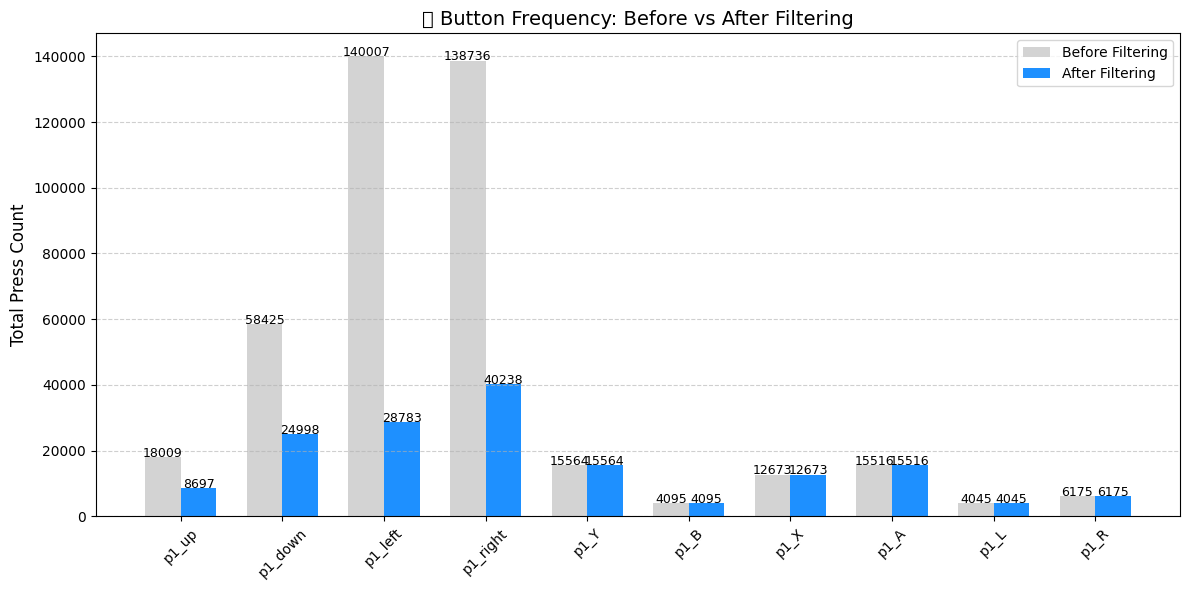

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Keep button_cols in your desired order
button_cols = ['p1_up', 'p1_down', 'p1_left', 'p1_right',
               'p1_Y', 'p1_B', 'p1_X', 'p1_A', 'p1_L', 'p1_R']

# Button counts WITHOUT sorting — respects button_cols order
before_counts = verify_df[button_cols].sum()
after_counts = balanced_df[button_cols].sum()

x = np.arange(len(button_cols))
width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, before_counts, width, label='Before Filtering', color='lightgray')
bars2 = plt.bar(x + width/2, after_counts, width, label='After Filtering', color='dodgerblue')

# Label bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, f'{int(height)}', ha='center', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50, f'{int(height)}', ha='center', fontsize=9)

plt.xticks(x, button_cols, rotation=45)
plt.ylabel("Total Press Count", fontsize=12)
plt.title("🎮 Button Frequency: Before vs After Filtering", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [25]:
def create_sequences(df, sequence_length, button_cols):
    df = df.copy()
    
    # Drop button columns from input features
    feature_cols = [col for col in df.columns if col not in button_cols]
    feature_data = df[feature_cols].to_numpy(dtype='float32')
    target_data = df[button_cols].to_numpy(dtype='float32')

    num_sequences = len(df) - sequence_length

    # Build input sequences efficiently using NumPy strides
    X = np.lib.stride_tricks.sliding_window_view(feature_data, (sequence_length, feature_data.shape[1]))
    X = X.reshape(-1, sequence_length, feature_data.shape[1])[:num_sequences]

    # The corresponding y values are the next-row targets after each sequence
    y = target_data[sequence_length:]

    return X, y


In [26]:
def create_sequences(df, sequence_length, button_cols):
    feature_cols = [col for col in df.columns if col not in button_cols]
    X = df[feature_cols].to_numpy(dtype='float32')
    y = df[button_cols].to_numpy(dtype='float32')
    X_seq = np.lib.stride_tricks.sliding_window_view(X, (sequence_length, X.shape[1]))
    X_seq = X_seq.reshape(-1, sequence_length, X.shape[1])[:len(df) - sequence_length]
    y_seq = y[sequence_length:]
    return X_seq, y_seq

sequence_length = 25
X, y = create_sequences(balanced_df, sequence_length, button_cols)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(128, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.relu(self.fc1(lstm_out[:, -1, :]))
        out = self.dropout(out)
        return self.sigmoid(self.out(out))

input_size = X.shape[2]
output_size = y.shape[1]
model = LSTMModel(input_size, 128, output_size).to(device)

In [30]:

# Loss & Optimizer

label_counts = y_train.sum(axis=0)
weights = 1.0 / (label_counts + 1e-6)
weights = weights / weights.max()
weights = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.BCELoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
print(weights)

tensor([0.4622, 0.1613, 0.1402, 0.1002, 0.2602, 0.9838, 0.3174, 0.2588, 1.0000,
        0.6508], device='cuda:0')


In [32]:

# Dataloaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=64)

In [33]:
num_epochs = 50
threshold = 0.5

for epoch in range(num_epochs):
    model.train()
    total_loss = correct = total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (preds > threshold).eq(yb).sum().item()
        total += yb.numel()
    train_acc = correct / total

    model.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            val_correct += (preds > threshold).eq(yb).sum().item()
            val_total += yb.numel()
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 156.8502 Acc: 0.9196 | Val Loss: 33.5012 Acc: 0.9276
Epoch 2/50 | Train Loss: 128.7499 Acc: 0.9327 | Val Loss: 30.3631 Acc: 0.9360
Epoch 3/50 | Train Loss: 119.7677 Acc: 0.9367 | Val Loss: 28.9750 Acc: 0.9386
Epoch 4/50 | Train Loss: 113.7132 Acc: 0.9389 | Val Loss: 27.6785 Acc: 0.9404
Epoch 5/50 | Train Loss: 108.9413 Acc: 0.9406 | Val Loss: 26.6788 Acc: 0.9421
Epoch 6/50 | Train Loss: 104.9125 Acc: 0.9419 | Val Loss: 25.6909 Acc: 0.9430
Epoch 7/50 | Train Loss: 101.2236 Acc: 0.9432 | Val Loss: 25.0088 Acc: 0.9440
Epoch 8/50 | Train Loss: 98.2273 Acc: 0.9442 | Val Loss: 24.3944 Acc: 0.9446
Epoch 9/50 | Train Loss: 95.5984 Acc: 0.9453 | Val Loss: 23.7758 Acc: 0.9466
Epoch 10/50 | Train Loss: 93.1835 Acc: 0.9460 | Val Loss: 23.6190 Acc: 0.9470
Epoch 11/50 | Train Loss: 91.3371 Acc: 0.9471 | Val Loss: 23.1038 Acc: 0.9476
Epoch 12/50 | Train Loss: 89.7316 Acc: 0.9476 | Val Loss: 22.9286 Acc: 0.9479
Epoch 13/50 | Train Loss: 88.1941 Acc: 0.9482 | Val Loss: 22.5732 

In [34]:
# ✅ Save PyTorch model
torch.save(model.state_dict(), "lstm_model.pt")

# ✅ Save Scaler
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [35]:
!pip freeze > requirements.txt